<h2 align="center"> Time Series Analysis </h2>

---

## Data:
- Web Scrapted weather data of duration 01 Jan 2019 to 30 Oct 2021 from https://www.estesparkweather.net

## Objective:
- Objective is to Forecast the temperature in Nov 2022 at Estes Park, Colorado.

In [3]:

from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 

#from statsmodels import stattools
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from matplotlib.pylab import rcParams

import re
import tqdm
import requests
from bs4 import BeautifulSoup
import warnings 
from prophet import Prophet
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
### Data collection

In [4]:
range_date = pd.date_range(start = '1/1/2019',end = '31/10/2021',freq = 'M')
print(range_date)
dates = [str(i)[:4] + str(i)[5:7] for i in range_date]


DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31'],
              dtype='datetime64[ns]', freq='M')


In [5]:
# Web Scraping

df_list = []
index = []
for k in tqdm.tqdm_notebook(range(len(dates))):
    
    url = f"http://www.estesparkweather.net/archive_reports.php?date={dates[k]}" 
    
    page = requests.get(url)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    table = soup.find_all('table')
    
    parsed_data = [row.text.splitlines() for row in table]
    parsed_data = parsed_data[:-9]
    
    for l in range(len(parsed_data)):
        parsed_data[l] = parsed_data[l][2:len(parsed_data[l]):3]
        
    for i in range(len(parsed_data)):
        c = ['.'.join(re.findall("\d+",str(parsed_data[i][j].split()[:5]))) for j in range(len(parsed_data[i]))]
        df_list.append(c)
        index.append(dates[k] + c[0])
      

  0%|          | 0/34 [00:00<?, ?it/s]

In [6]:
data = [df_list[i][1:] for i in range(len(df_list)) if len(df_list[i][1:]) == 19]

In [7]:
# setting the index

dates = pd.date_range(start='2019-01-01', freq='d', periods=1029)

In [8]:
# setting the column
col = ['Average temperature (°F)', 'Average humidity (%)',
'Average dewpoint (°F)', 'Average barometer (in)',
'Average windspeed (mph)', 'Average gustspeed (mph)',
'Average direction (°deg)', 'Rainfall for month (in)',
'Rainfall for year (in)', 'Maximum rain per minute',
'Maximum temperature (°F)', 'Minimum temperature (°F)',
'Maximum humidity (%)', 'Minimum humidity (%)', 'Maximum pressure',
'Minimum pressure', 'Maximum windspeed (mph)',
'Maximum gust speed (mph)', 'Maximum heat index (°F)']
final_df = pd.DataFrame(data, columns = col, index = dates)

In [9]:
# changing alll data types to float for processing

final_df = final_df.astype("float64")

## Data Analysis

### Task 1: Creating a seperate data frame for our column of interest

In [10]:
final_df.columns

Index(['Average temperature (°F)', 'Average humidity (%)',
       'Average dewpoint (°F)', 'Average barometer (in)',
       'Average windspeed (mph)', 'Average gustspeed (mph)',
       'Average direction (°deg)', 'Rainfall for month (in)',
       'Rainfall for year (in)', 'Maximum rain per minute',
       'Maximum temperature (°F)', 'Minimum temperature (°F)',
       'Maximum humidity (%)', 'Minimum humidity (%)', 'Maximum pressure',
       'Minimum pressure', 'Maximum windspeed (mph)',
       'Maximum gust speed (mph)', 'Maximum heat index (°F)'],
      dtype='object')

In [11]:
to_drop = ['Average humidity (%)',"Average windspeed (mph)", 
       'Average dewpoint (°F)', 'Average barometer (in)',
        'Average gustspeed (mph)',
       'Average direction (°deg)', 'Rainfall for month (in)',
       'Rainfall for year (in)', 'Maximum rain per minute',
       'Maximum temperature (°F)', 'Minimum temperature (°F)',
       'Maximum humidity (%)', 'Minimum humidity (%)', 'Maximum pressure',
       'Minimum pressure', 'Maximum windspeed (mph)',
       'Maximum gust speed (mph)', 'Maximum heat index (°F)']

In [12]:
df = final_df.drop(to_drop,axis=1)

### Task 2: Plotting the data

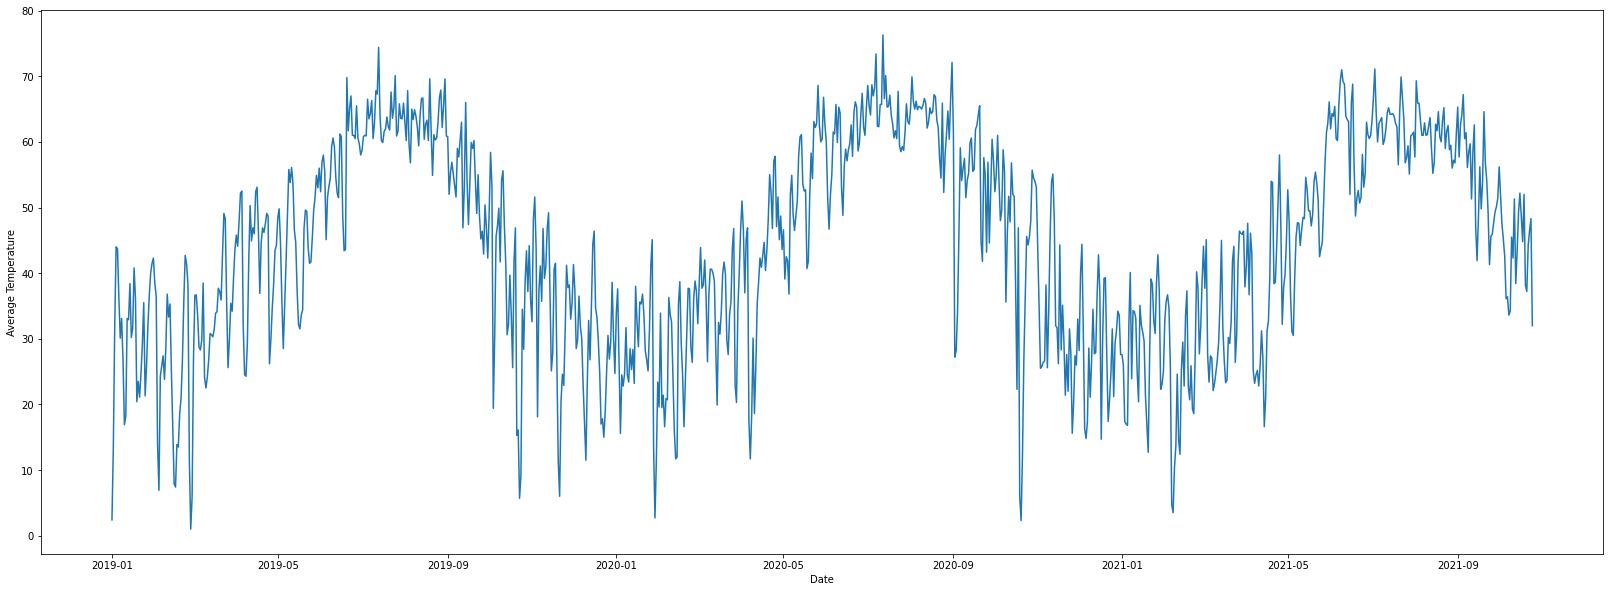

In [13]:
plt.figure(figsize=(28,10))
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.plot(final_df["Average temperature (°F)"])


### Task 3:  Decomposing Time Series:

- **The Seasonal component:** A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. A time series can contain multiple superimposed seasonal periods.

- **The Trend component:** A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes a trend is referred to as “changing direction” when it might go from an increasing trend to a decreasing trend.

- **The Cyclical component:** The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. The cyclical component is hard to isolate and it's often ‘left alone’ by combining it with the trend component.

- **The Noise component:** The noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns



<Figure size 432x288 with 0 Axes>

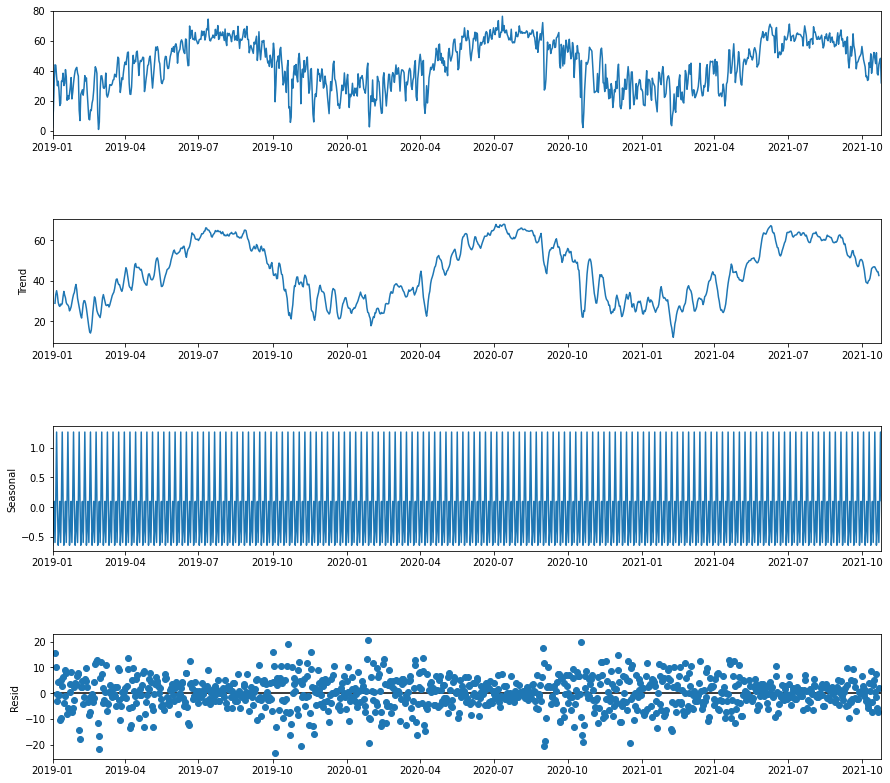

In [14]:
result = sm.tsa.seasonal_decompose(df, model='additive') #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)


### Task 4: Stationarity cheak

In [15]:
#Determine rolling statistics
##rolling window


In [16]:
def rolling_stats(df): 
    rolmean = df.rolling(window=30).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd = df.rolling(window=30).std()
    
    plt.figure(figsize=(28,10))
    plt.plot(df,color = "black", label = "Origanal")
    plt.plot(rolmean,color = "RED", label = "Mean")
    plt.plot(rolstd,color = "Green", label = 'Standered deviation')
    plt.legend(loc='best')
    plt.title("Rolling Statistics")
    plt.show(block=False)
    

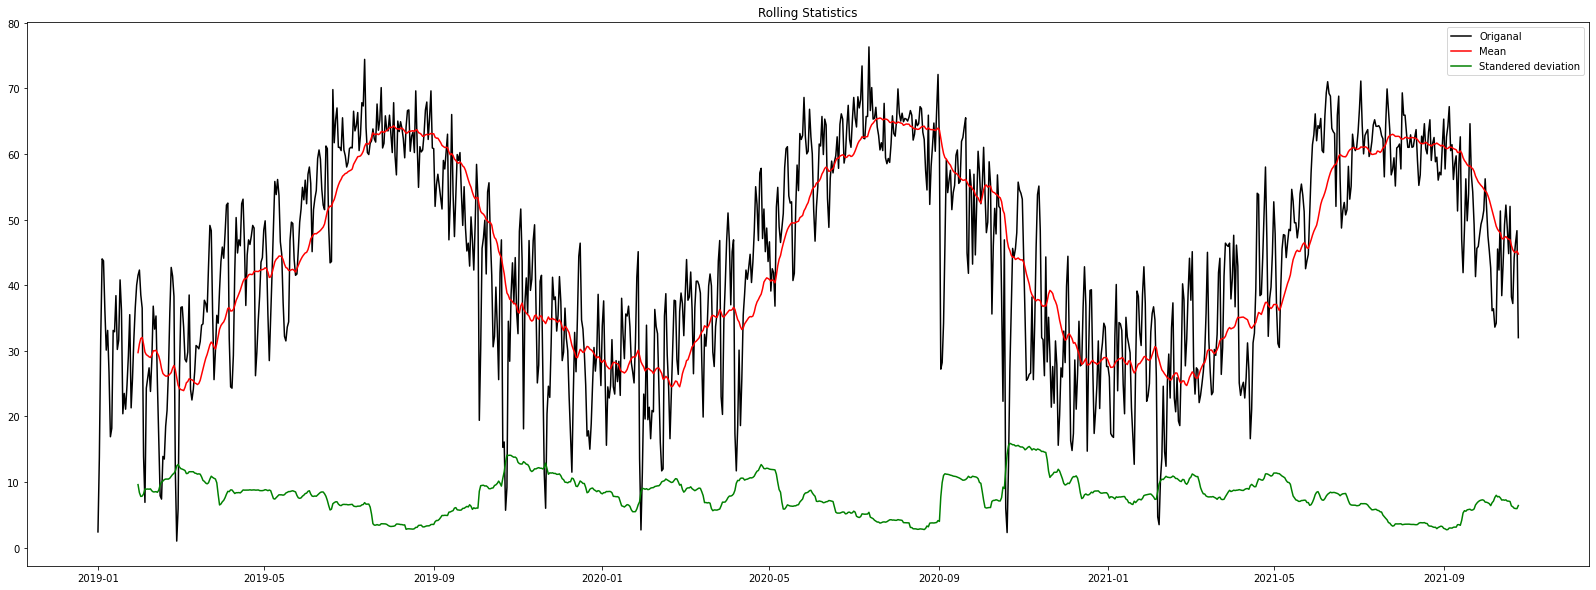

In [17]:
rolling_stats(final_df["Average temperature (°F)"])


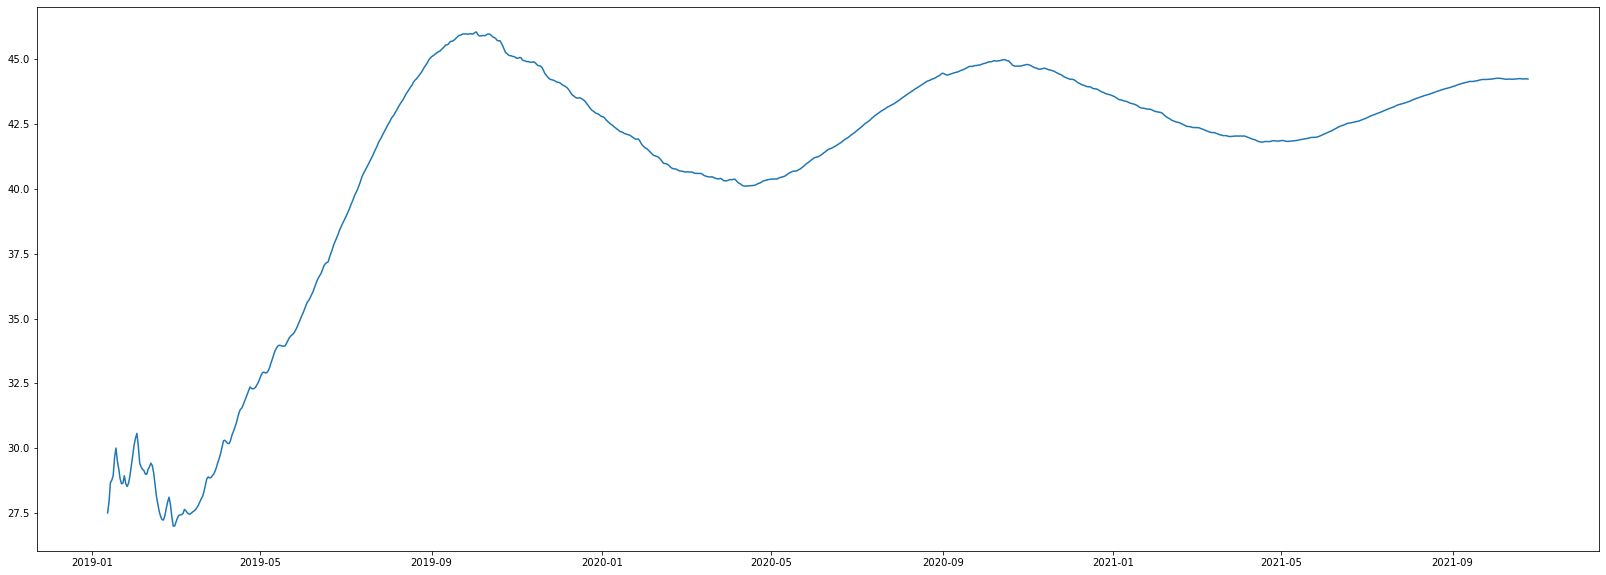

In [18]:
#expanding window
plt.figure(figsize=(28,10))
plt.plot(df.expanding(min_periods=12).mean())


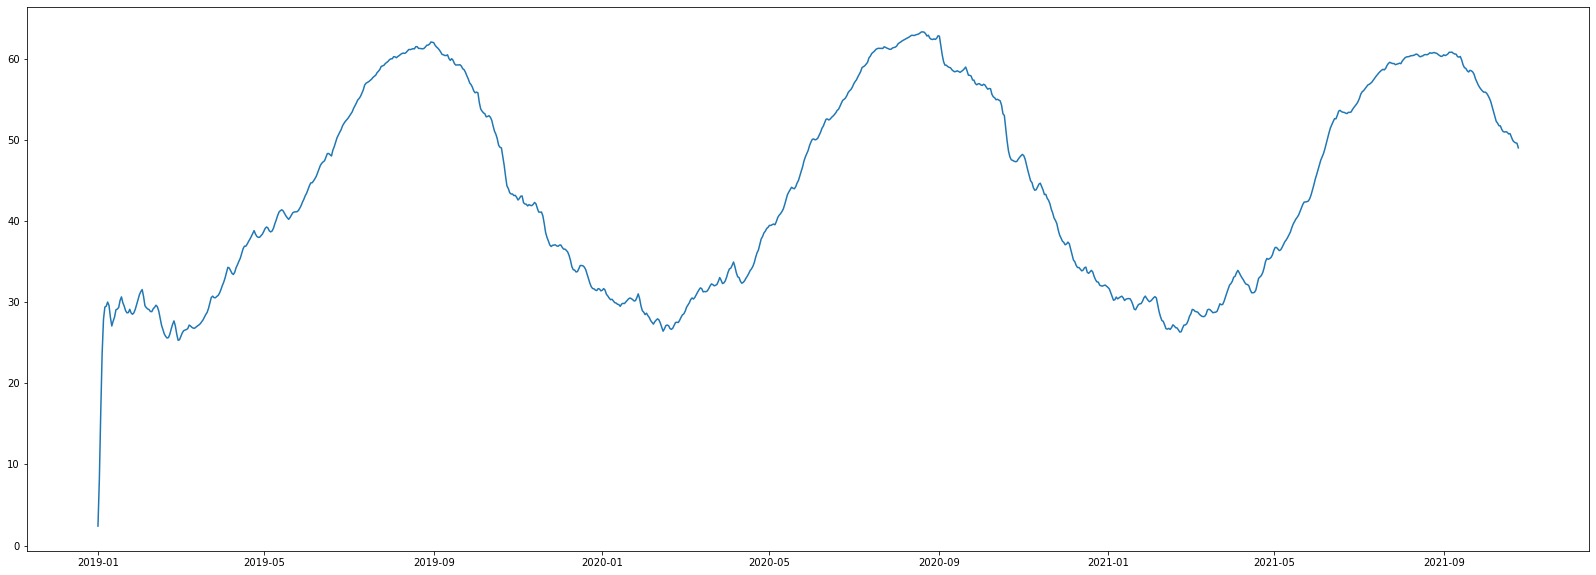

In [19]:
#exponantial moving avg
plt.figure(figsize=(28,10))
plt.plot(df.ewm(span=60, min_periods=0, adjust = True).mean())


In [20]:
#Performing Augmented Dickey–Fuller test:
def ADFT(df):
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(df, autolag='AIC')

    useful_values =[v for v in dftest[:4]]
    useful_values.extend([dftest[4]["1%"],dftest[4]["5%"],dftest[4]["10%"]])
    res = pd.DataFrame({"Lables":["Test Stats","P-Value","#Lag Used","Number of Observation Used","Critical Value for 1%","Critical Value for 5%","Critical Value for 10%" ],"Value":useful_values})

    Pvalue = dftest[1]
    cutoff = 0.1
    if Pvalue < cutoff:    
        print('P-value = %.4f. The series is likely stationary.' % Pvalue)
    else:
        print('P-value = %.4f. The series is likely non-stationary.' % Pvalue)
    return res
 

In [21]:
res = ADFT(df)
res


Results of Dickey Fuller Test:
P-value = 0.1484. The series is likely non-stationary.


Lables        Value
0                  Test Stats    -2.376836
1                     P-Value     0.148381
2                   #Lag Used    12.000000
3  Number of Observation Used  1016.000000
4       Critical Value for 1%    -3.436803
5       Critical Value for 5%    -2.864389
6      Critical Value for 10%    -2.568287

- Our data is non - stationary it needs to be transformed

### Task 5:  Data Transformation to achieve Stationarity (Data Munging):

### Method 1 : Time shifting
- Time shifting is done to remove the trends present in the data 

In [22]:
first_diff = df - df.shift(1)

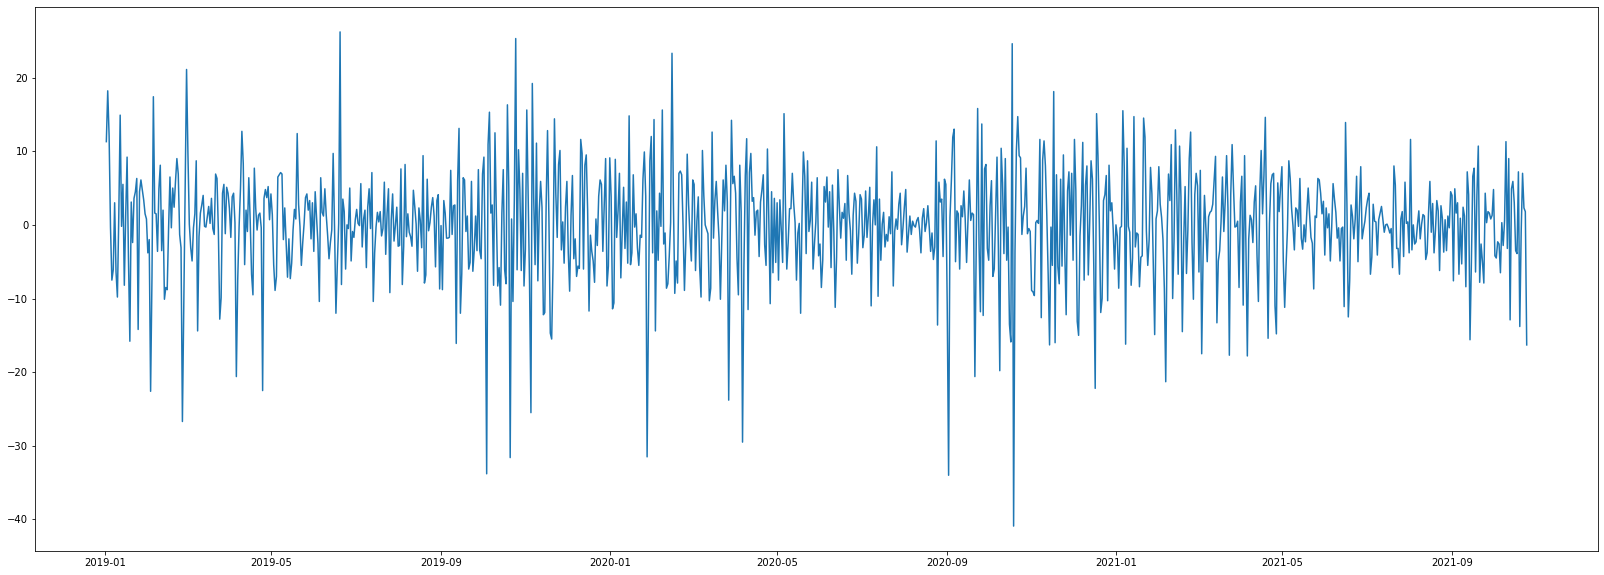

In [23]:
plt.figure(figsize=(28,10))
plt.plot(first_diff)


In [24]:
first_diff.dropna(inplace=True)


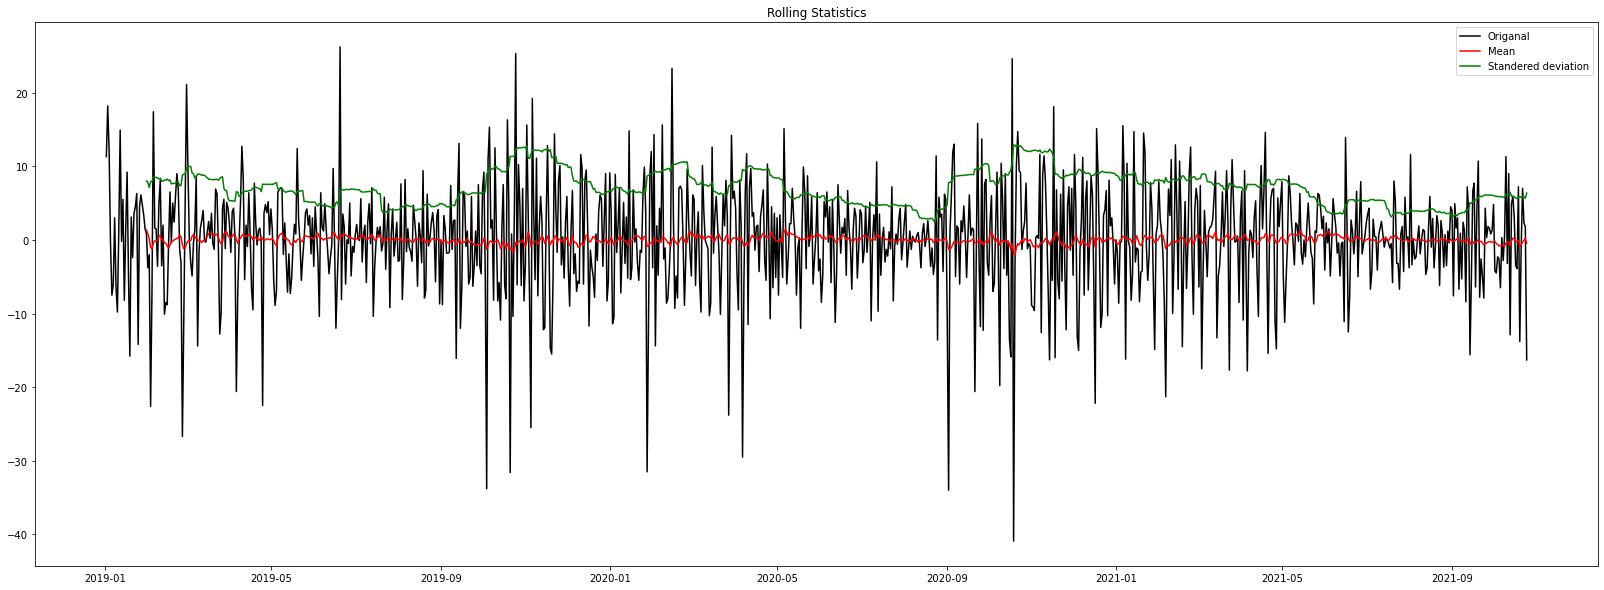

In [25]:
#rolling stats

rolling_stats(first_diff)


In [26]:
#Performing Augmented Dickey–Fuller test:
res = ADFT(first_diff)
res 


Results of Dickey Fuller Test:
P-value = 0.0000. The series is likely stationary.


Lables         Value
0                  Test Stats -9.469742e+00
1                     P-Value  4.136963e-16
2                   #Lag Used  2.200000e+01
3  Number of Observation Used  1.005000e+03
4       Critical Value for 1% -3.436873e+00
5       Critical Value for 5% -2.864420e+00
6      Critical Value for 10% -2.568304e+00

In [27]:
second_diff = df - df.shift(2)

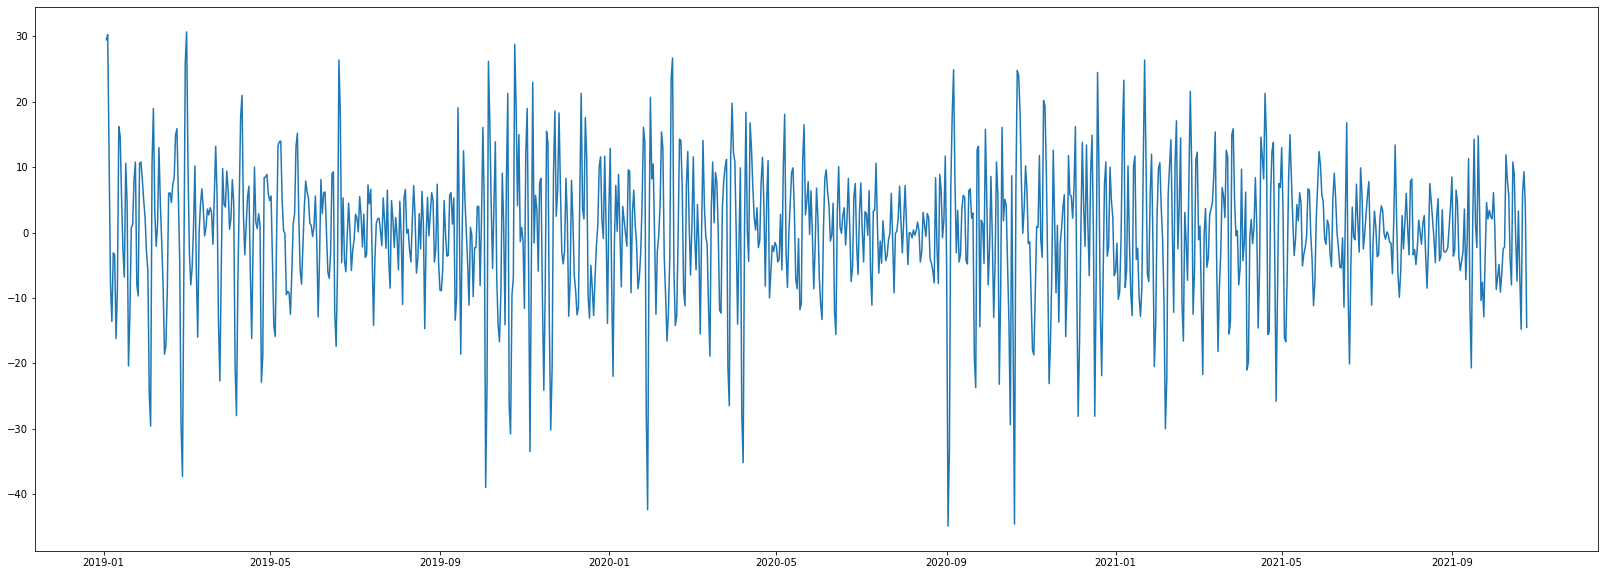

In [28]:
plt.figure(figsize=(28,10))
plt.plot(second_diff)


In [29]:
second_diff.dropna(inplace=True)


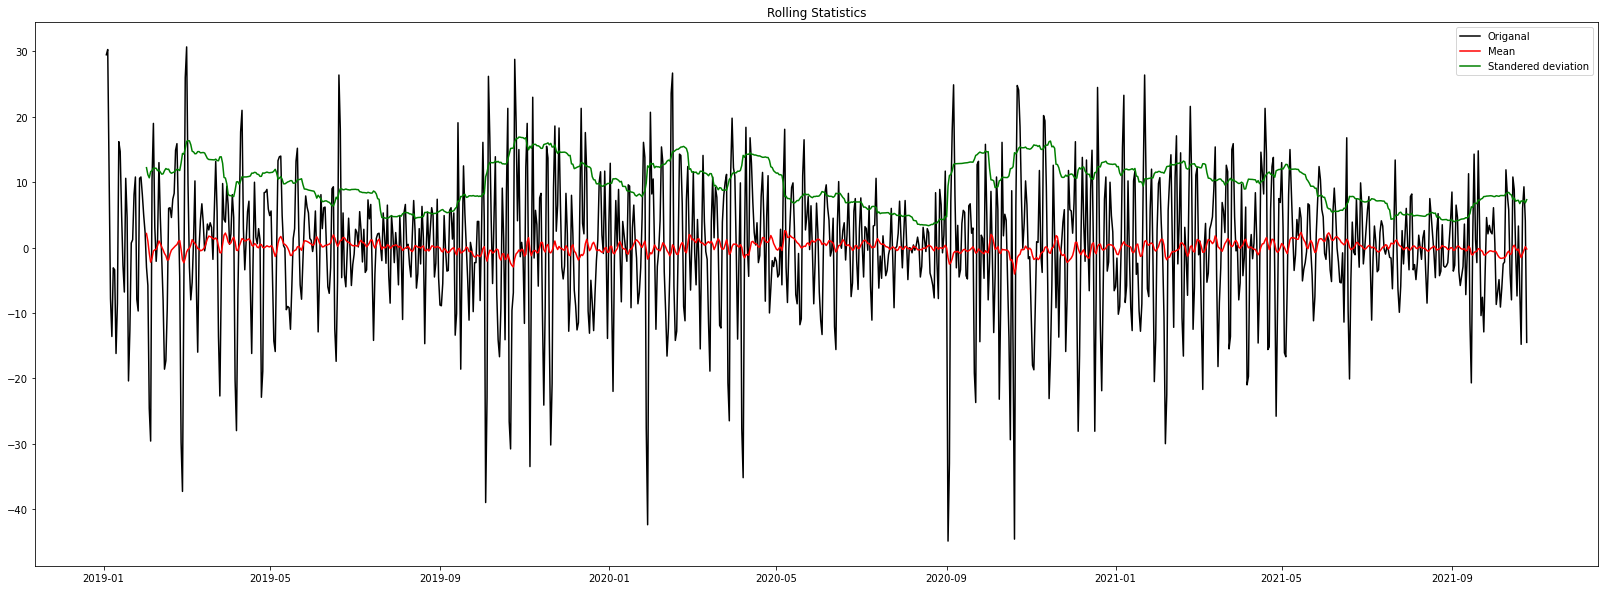

In [30]:
rolling_stats(second_diff)


In [31]:
result = ADFT(second_diff)
result


Results of Dickey Fuller Test:
P-value = 0.0000. The series is likely stationary.


Lables         Value
0                  Test Stats -9.637546e+00
1                     P-Value  1.551964e-16
2                   #Lag Used  2.100000e+01
3  Number of Observation Used  1.005000e+03
4       Critical Value for 1% -3.436873e+00
5       Critical Value for 5% -2.864420e+00
6      Critical Value for 10% -2.568304e+00

### Method 2 : Log Transform 

In [32]:
log_data = np.log(df)


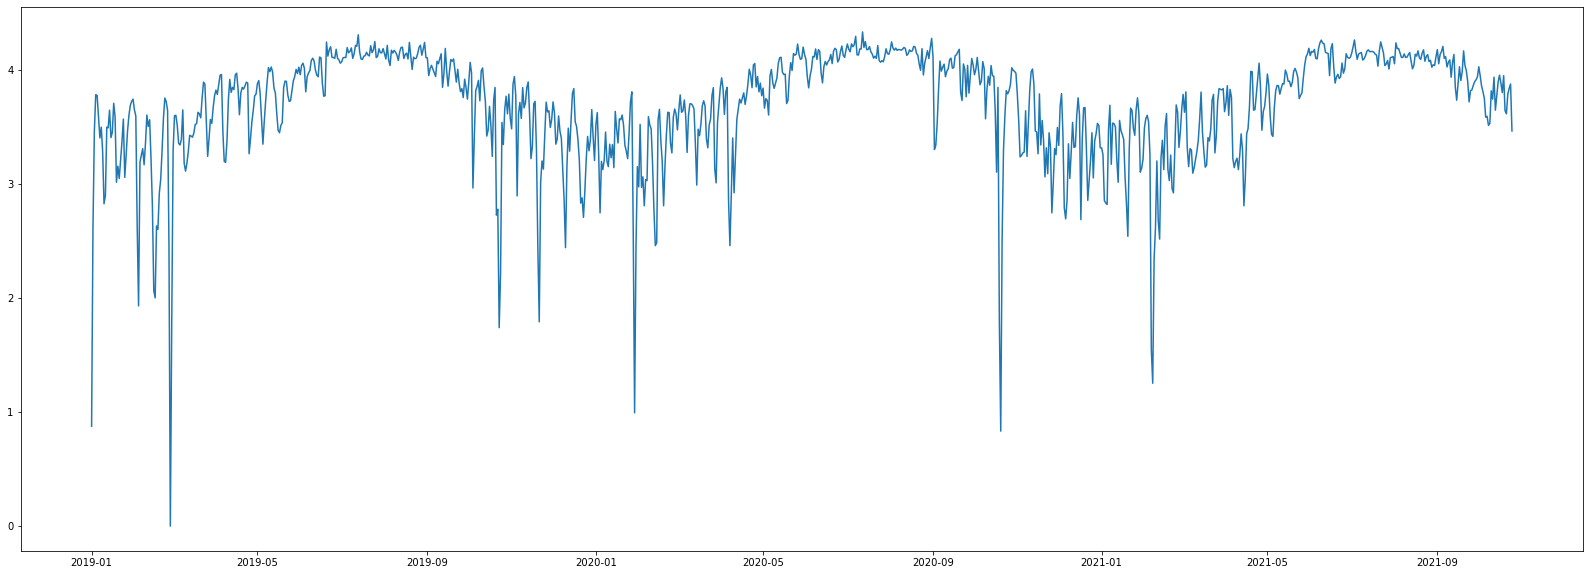

In [33]:
plt.figure(figsize=(28,10))
plt.plot(log_data)


In [34]:
log_data.dropna(inplace=True)


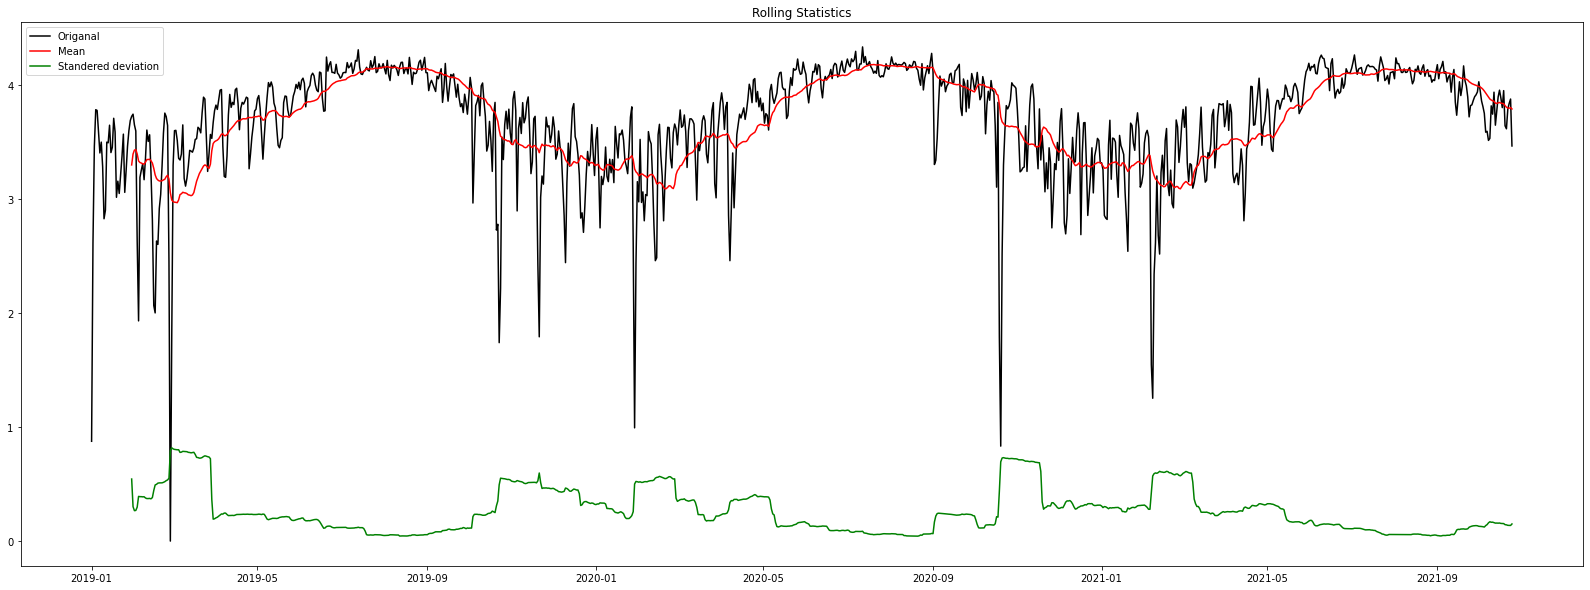

In [35]:
rolling_stats(log_data)


In [36]:
res = ADFT(log_data)
res

Results of Dickey Fuller Test:
P-value = 0.0144. The series is likely stationary.


Lables        Value
0                  Test Stats    -3.311721
1                     P-Value     0.014363
2                   #Lag Used    11.000000
3  Number of Observation Used  1017.000000
4       Critical Value for 1%    -3.436796
5       Critical Value for 5%    -2.864386
6      Critical Value for 10%    -2.568285

In [37]:
log_diff = log_data-log_data.shift(1)

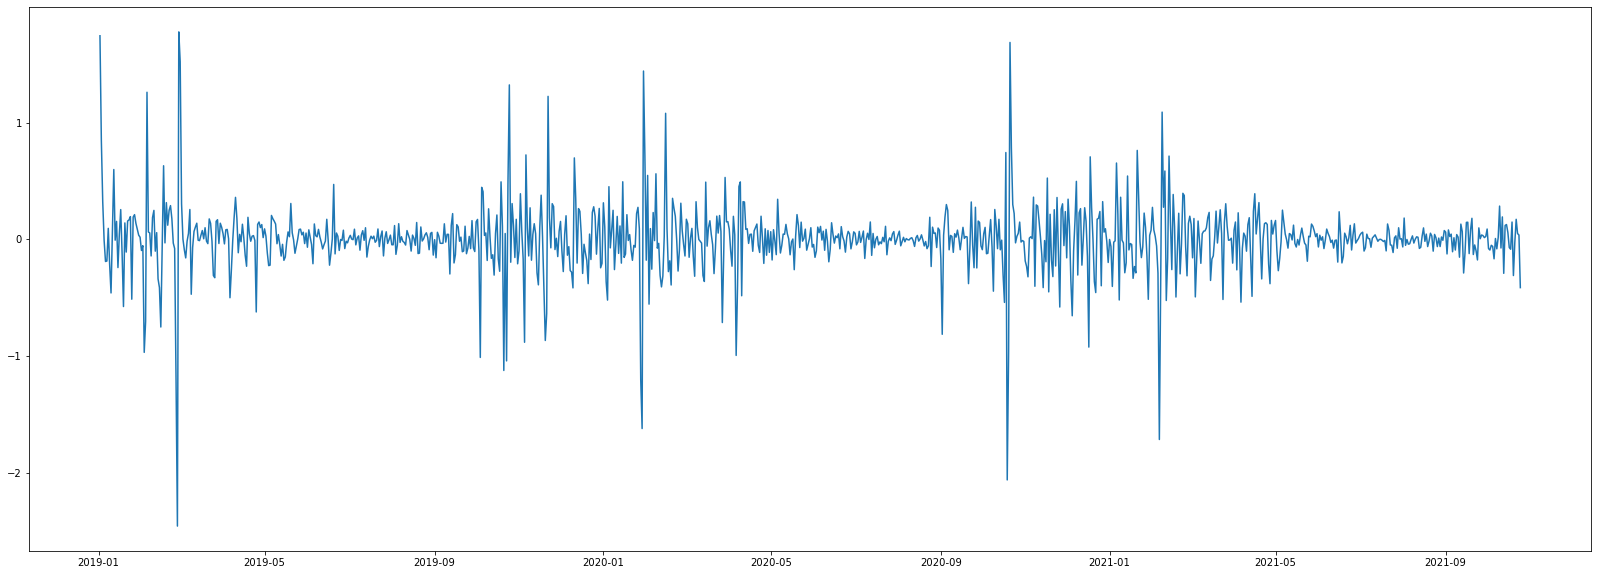

In [38]:
plt.figure(figsize=(28,10))
plt.plot(log_diff)

In [39]:
log_diff.dropna(inplace=True)

In [40]:
res = ADFT(log_diff)
res

Results of Dickey Fuller Test:
P-value = 0.0000. The series is likely stationary.


Lables         Value
0                  Test Stats -1.204067e+01
1                     P-Value  2.736952e-22
2                   #Lag Used  1.700000e+01
3  Number of Observation Used  1.010000e+03
4       Critical Value for 1% -3.436841e+00
5       Critical Value for 5% -2.864406e+00
6      Critical Value for 10% -2.568296e+00

### Method 3 : Exponatial transformation:

In [41]:
exponential_df = df.ewm(halflife=12, min_periods=0, adjust=True).mean()

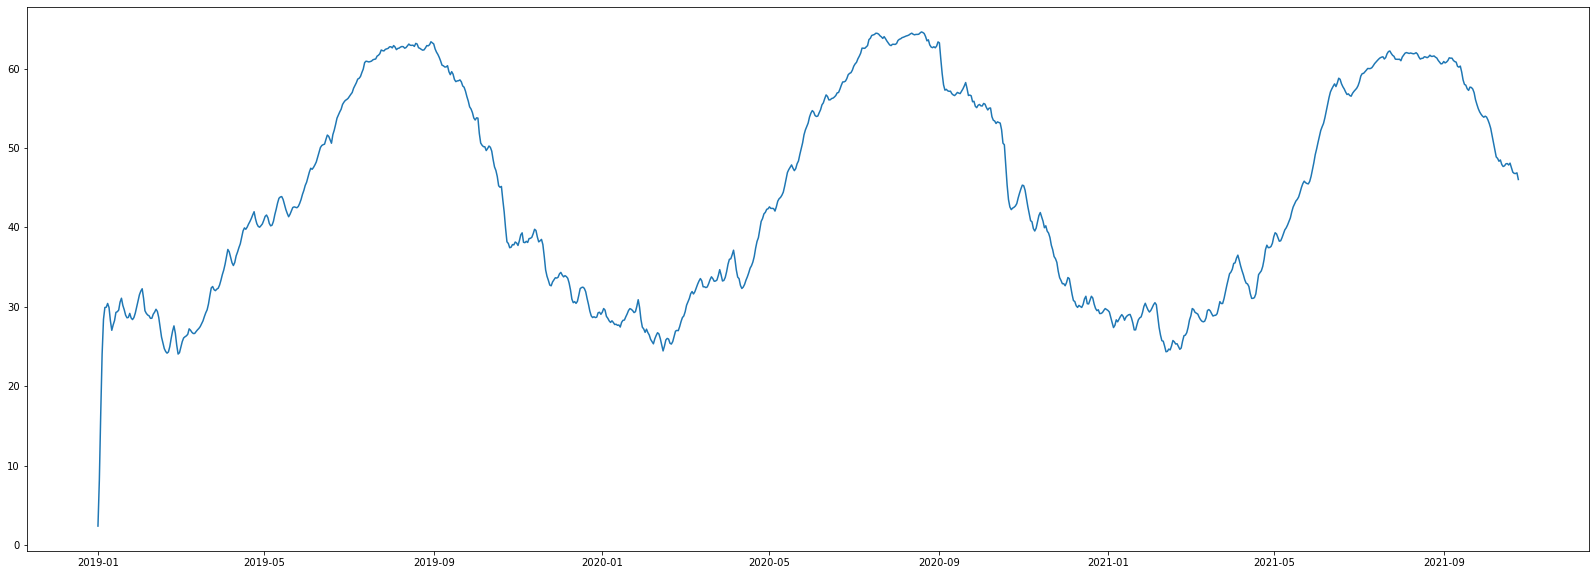

In [42]:
plt.figure(figsize=(28,10))
plt.plot(exponential_df)


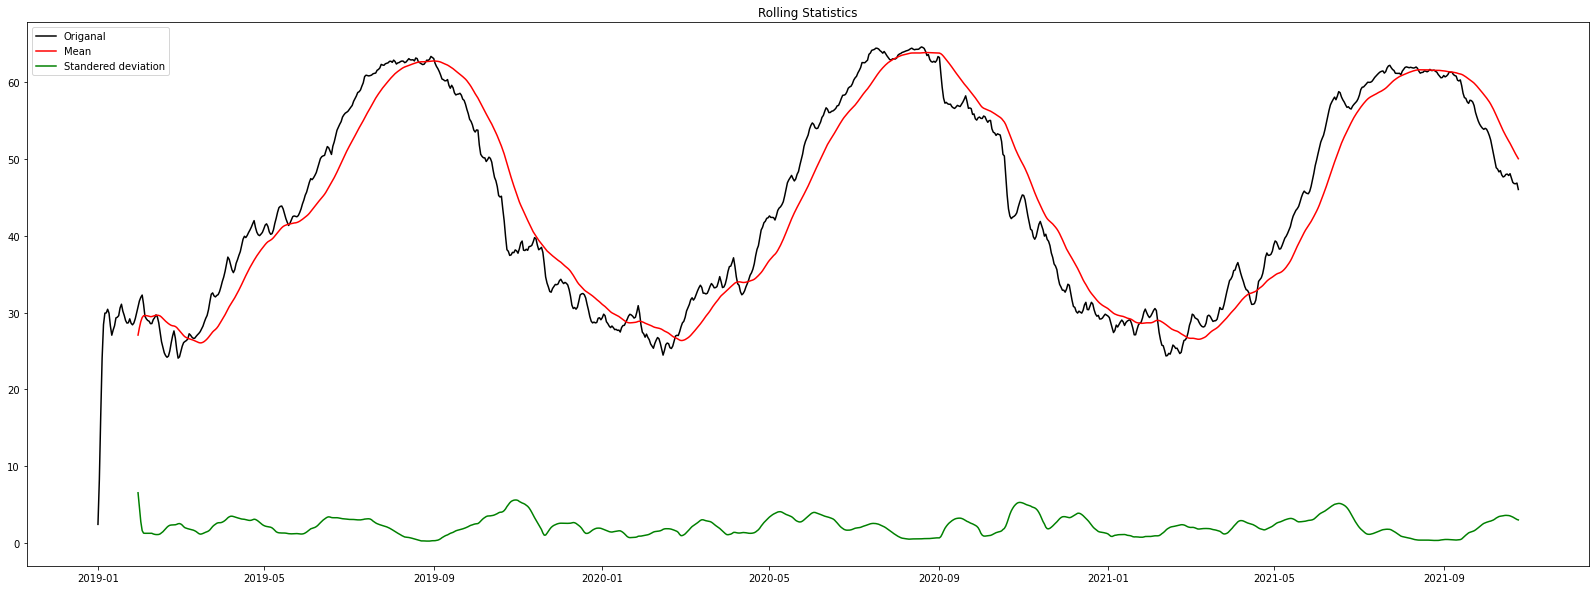

In [43]:
#rolling statistics 
rolling_stats(exponential_df)


In [44]:
res = ADFT(exponential_df)
res


Results of Dickey Fuller Test:
P-value = 0.3905. The series is likely non-stationary.


Lables        Value
0                  Test Stats    -1.779774
1                     P-Value     0.390549
2                   #Lag Used    12.000000
3  Number of Observation Used  1016.000000
4       Critical Value for 1%    -3.436803
5       Critical Value for 5%    -2.864389
6      Critical Value for 10%    -2.568287

In [45]:
exp_diff = exponential_df-exponential_df.shift(1)


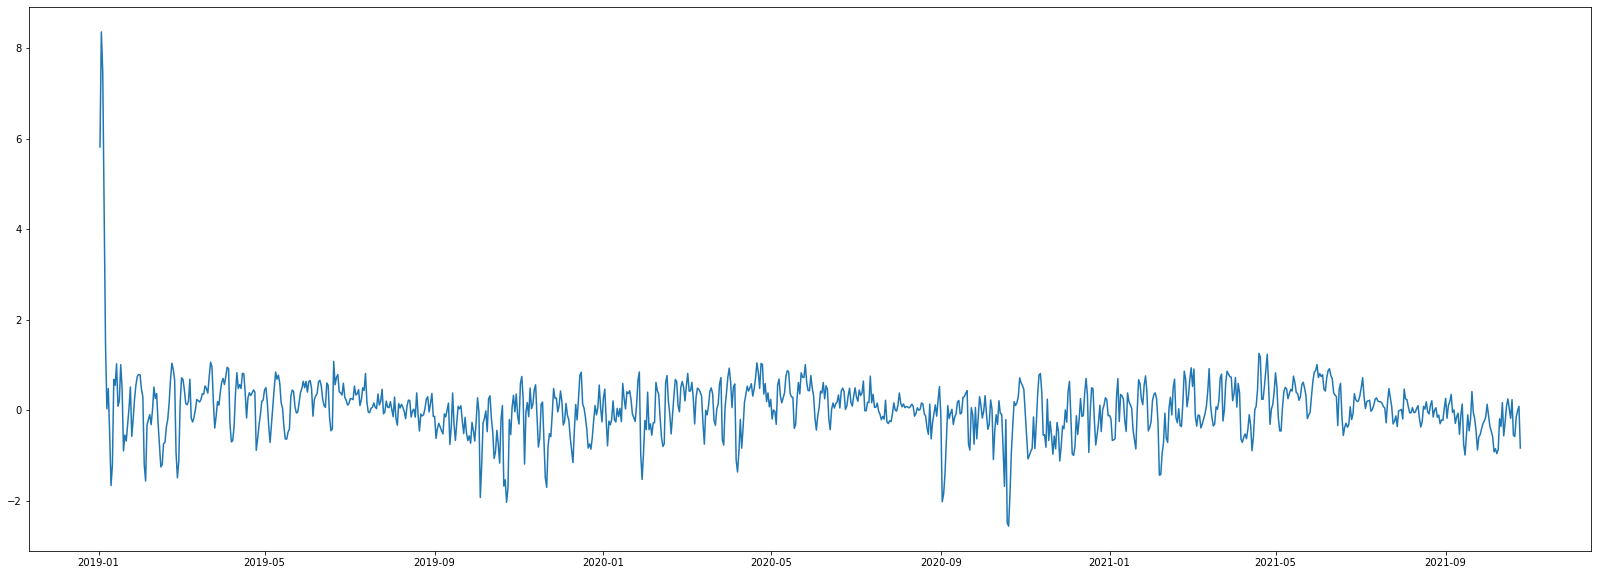

In [46]:
plt.figure(figsize=(28,10))
plt.plot(exp_diff)


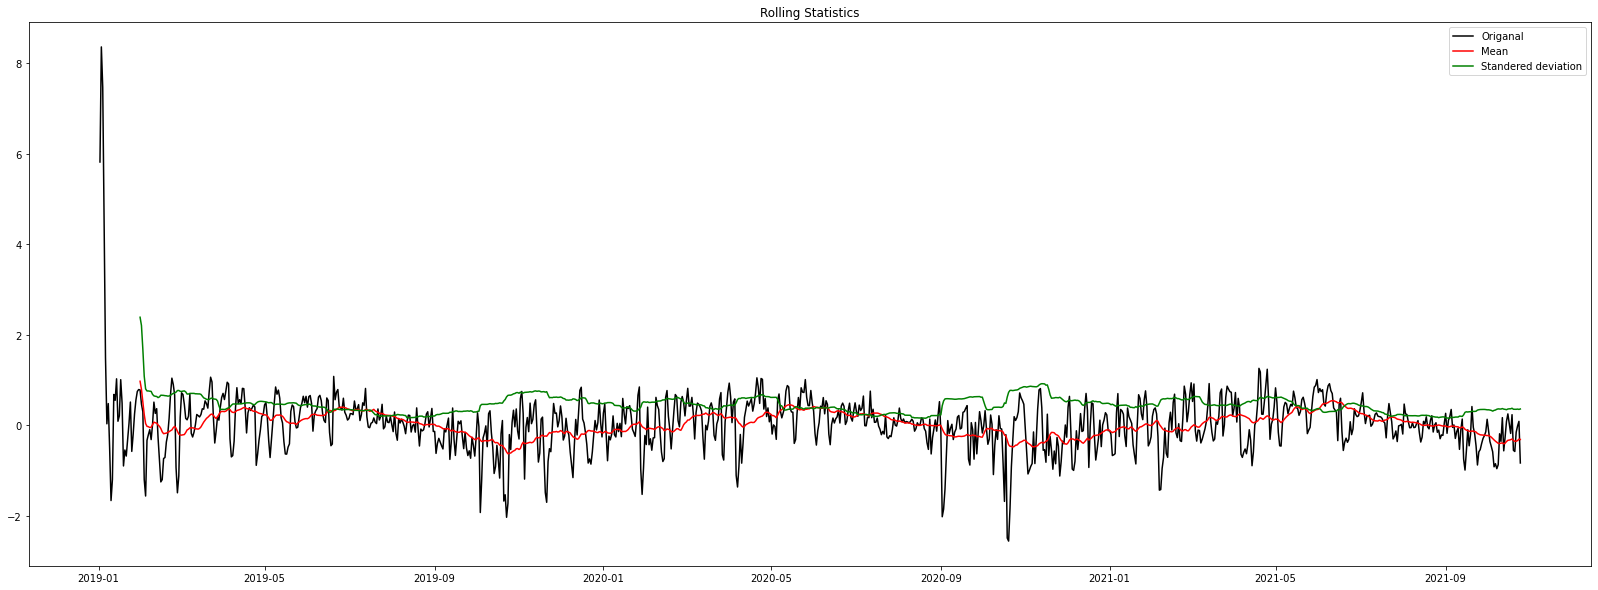

In [47]:
rolling_stats(exp_diff)


In [48]:
exp_diff.dropna(inplace=True)
result = ADFT(exp_diff)
result


Results of Dickey Fuller Test:
P-value = 0.0000. The series is likely stationary.


Lables         Value
0                  Test Stats -6.754893e+00
1                     P-Value  2.888447e-09
2                   #Lag Used  1.100000e+01
3  Number of Observation Used  1.016000e+03
4       Critical Value for 1% -3.436803e+00
5       Critical Value for 5% -2.864389e+00
6      Critical Value for 10% -2.568287e+00

### Observation:
- We have tried out 3 Methods: Time shift, Log transformation, & Exp decay. 
- We can use both log trasformation and exponantial decay. 
- We will apply the log transformation as it is convineant to convert back to the origanal data from log transformation.

### Task 6: Data Splitting

In [49]:
train_df = log_data[0:1015]


In [50]:
test_df = log_data[1015:]


In [51]:
test_dfS = log_data[1015:]


### Plotting ACF & PACF
- For getting insites of model parameter p,d,q

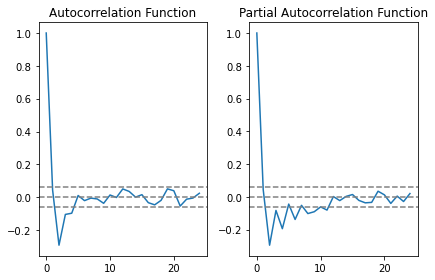

In [52]:
lag_acf = acf(log_diff,nlags=24)
lag_pacf = pacf(log_diff,nlags=24)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(final_df["Average temperature (°F)"])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(final_df["Average temperature (°F)"])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()


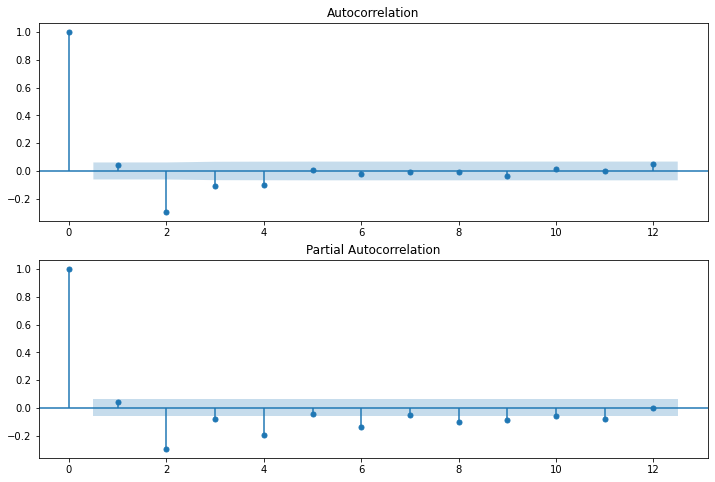

In [53]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_diff, lags=12, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_diff, lags=12, ax=ax2)


### Auto Arima 

In [54]:
from pmdarima import auto_arima


In [55]:
fit = auto_arima(train_df,trace=True, surpress_warning = True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=174.683, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=401.966, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=401.789, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=398.667, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=400.060, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=173.620, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=211.814, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=268.681, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=175.274, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=183.090, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=189.544, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=175.063, Time=1.56 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=172.036, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=210.081, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=267.1

## Arima Model

In [56]:
arima_model = sm.tsa.arima.ARIMA(endog = train_df,order=(6, 1 ,4))


In [57]:
ar_model= arima_model.fit()
ar_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Average temperature (°F)   No. Observations:                 1015
Model:                       ARIMA(6, 1, 4)   Log Likelihood                 -74.705
Date:                      Tue, 12 Jul 2022   AIC                            171.411
Time:                              00:09:59   BIC                            225.549
Sample:                          01-01-2019   HQIC                           191.973
                               - 10-11-2021                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4054      0.476     -0.852      0.394      -1.339       0.528
ar.L2          0.3796      0.397      0.957      0.339      -0.398       1.157
ar.L3          0.1956      0.075      2.623      0.009       0.049       0.342
ar.L4         -0.3020      0.109     -2.760      0.006      -0.516      -0.088
ar.L5          0.0656      0.110      0.597      0.550      -0.150       0.281
ar.L6         -0.0803      0.036     -2.244      0.025      -0.150      -0.010
ma.L1          0.3137      0.478      0.656      0.512      -0.623       1.251
ma.L2         -0.9016      0.356     -2.536      0.011      -1.599      -0.205
ma.L3         -0.5281      0.327     -1.617      0.106      -1.168       0.112
ma.L4          0.3037      0.373      0.814      0.416      -0.428       1.035
sigma2         0.0677      0.001     65.236      0.000       0.066       0.070
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             16821.62
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -2.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction:

In [58]:
start_index = 1015
end_index = 1029
pred = ar_model.predict(start = start_index, end= end_index)  
#train_logdf[start_index:end_index][["Accidental deaths in USA", 'forecast']].plot(figsize=(12, 8))


In [59]:
test_df["Prediction"]=pred

In [60]:
def error(y_true, y_pred):
    mad = np.mean(abs((y_true-y_pred)))
    MSE = np.mean(np.square((y_true-y_pred)))
    RMSE = np.sqrt(MSE)
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    print('MAD: %.2f  \nRMSE: %.2f \nSMAPE: %.2f \nMAPE: %.2f'% (mad,RMSE,smape,mape))
    

In [61]:
error(test_df["Average temperature (°F)"],test_df['Prediction'])


MAD: 0.12  
RMSE: 0.15 
SMAPE: 3.15 
MAPE: 3.18


<AxesSubplot:>

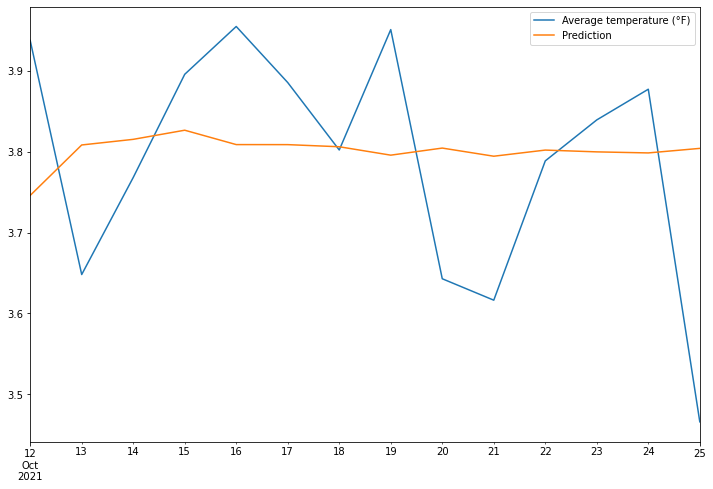

In [62]:
test_df[["Average temperature (°F)", 'Prediction']].plot(figsize=(12, 8))


## Actual Temperature and Predicted Temperature:

In [63]:
data = np.exp(test_df)

In [64]:
data

Average temperature (°F)  Prediction
2021-10-12                      51.3   42.351284
2021-10-13                      38.4   45.079587
2021-10-14                      43.3   45.394324
2021-10-15                      49.2   45.910563
2021-10-16                      52.2   45.100847
2021-10-17                      48.7   45.098447
2021-10-18                      44.8   44.980173
2021-10-19                      52.0   44.514512
2021-10-20                      38.2   44.906567
2021-10-21                      37.2   44.456294
2021-10-22                      44.2   44.795294
2021-10-23                      46.5   44.696180
2021-10-24                      48.3   44.637694
2021-10-25                      32.0   44.889701

## Forecast for Nov 2021

In [67]:
start_index = 1035
end_index = 1049
forcast = ar_model.predict(start = start_index, end= end_index)

In [68]:
pd.set_option("display.max_rows", 15)
np.exp(forcast)

2021-11-01    44.771948
2021-11-02    44.578265
2021-11-03    44.687728
2021-11-04    44.681448
2021-11-05    44.597103
2021-11-06    44.738394
2021-11-07    44.587157
2021-11-08    44.706161
2021-11-09    44.647939
2021-11-10    44.637290
2021-11-11    44.704886
2021-11-12    44.606161
2021-11-13    44.704875
2021-11-14    44.633108
2021-11-15    44.661705
Freq: D, Name: predicted_mean, dtype: float64

---

# Sarima Model

In [69]:

sarima_model = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(6,2,4),seasonal_order=(1,1,2,12)).fit()

print(sarima_model.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96168D-01    |proj g|=  1.02637D+00


 This problem is unconstrained.



At iterate    5    f=  2.92199D-01    |proj g|=  1.48408D+00

At iterate   10    f=  1.87237D-01    |proj g|=  3.35389D-01

At iterate   15    f=  1.57954D-01    |proj g|=  2.29431D-02

At iterate   20    f=  1.48860D-01    |proj g|=  9.23597D-02

At iterate   25    f=  1.27475D-01    |proj g|=  3.09621D-01

At iterate   30    f=  1.08736D-01    |proj g|=  7.49539D-02

At iterate   35    f=  1.06548D-01    |proj g|=  8.63052D-03

At iterate   40    f=  1.06004D-01    |proj g|=  1.68655D-02

At iterate   45    f=  1.05977D-01    |proj g|=  1.46871D-03

At iterate   50    f=  1.05873D-01    |proj g|=  8.06845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [70]:
start_index = 1015
end_index = 1029
test_dfS['Prediction'] = sarima_model.predict(start = start_index, end= end_index, typ="labels")  

In [71]:
error(test_dfS["Average temperature (°F)"],test_dfS['Prediction'])

MAD: 0.14  
RMSE: 0.16 
SMAPE: 3.69 
MAPE: 3.70


<AxesSubplot:>

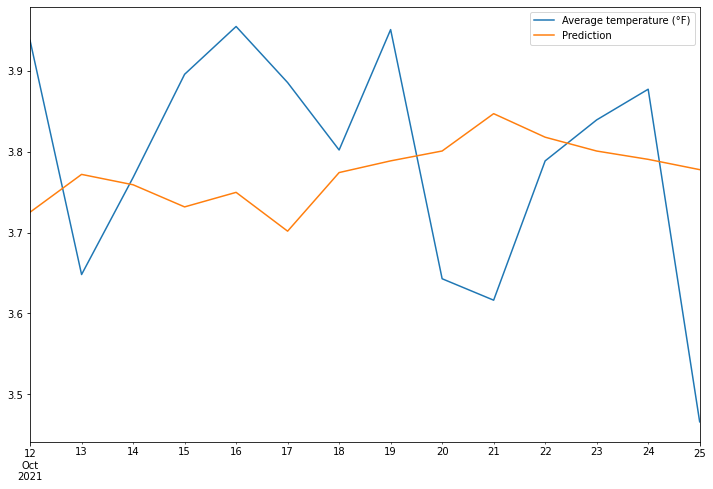

In [72]:
test_dfS[["Average temperature (°F)", 'Prediction']].plot(figsize=(12, 8))

## Forecast for Nov 2021 using SARIMA model:

In [73]:
start_index = 1035
end_index = 1049
forecast = sarima_model.predict(start = start_index, end= end_index, typ="labels")  

In [74]:
print(forecast)

2021-11-01    3.793116
2021-11-02    3.807663
2021-11-03    3.791286
2021-11-04    3.782273
2021-11-05    3.766369
2021-11-06    3.754598
2021-11-07    3.711277
2021-11-08    3.703365
2021-11-09    3.709467
2021-11-10    3.672841
2021-11-11    3.746543
2021-11-12    3.758772
2021-11-13    3.779942
2021-11-14    3.811491
2021-11-15    3.795092
Freq: D, Name: predicted_mean, dtype: float64


---

## Facebook prophet Forecasting :

In [65]:
df.reset_index(inplace=True)


In [66]:
df.rename(columns = {'index':'ds', 'Average temperature (°F)':'y'}, inplace = True)


In [67]:
df


ds     y
0    2019-01-01   2.4
1    2019-01-02  13.7
2    2019-01-03  31.9
3    2019-01-04  44.0
4    2019-01-05  43.7
...         ...   ...
1024 2021-10-21  37.2
1025 2021-10-22  44.2
1026 2021-10-23  46.5
1027 2021-10-24  48.3
1028 2021-10-25  32.0

[1029 rows x 2 columns]

In [68]:
train_prophet = df[0:1015]


In [69]:
m = Prophet()
m.fit(train_prophet)


00:09:59 - cmdstanpy - INFO - Chain [1] start processing
00:09:59 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
future = m.make_future_dataframe(periods=14)


In [71]:
future.tail()


ds
1024 2021-10-21
1025 2021-10-22
1026 2021-10-23
1027 2021-10-24
1028 2021-10-25

In [72]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds       yhat  yhat_lower  yhat_upper
1024 2021-10-21  33.917308   23.271023   45.549382
1025 2021-10-22  33.207882   23.187786   43.128172
1026 2021-10-23  34.159377   23.758144   45.806689
1027 2021-10-24  35.598795   25.366919   46.530764
1028 2021-10-25  34.778617   24.645725   45.442081

In [73]:
forecast['yhat'][1015:]


1015    36.544700
1016    36.237837
1017    36.058584
1018    34.601933
1019    34.833050
1020    35.594643
1021    34.153791
1022    32.894444
1023    33.338914
1024    33.917308
1025    33.207882
1026    34.159377
1027    35.598795
1028    34.778617
Name: yhat, dtype: float64

In [74]:
df["y"][1015:]


1015    51.3
1016    38.4
1017    43.3
1018    49.2
1019    52.2
1020    48.7
1021    44.8
1022    52.0
1023    38.2
1024    37.2
1025    44.2
1026    46.5
1027    48.3
1028    32.0
Name: y, dtype: float64

In [75]:
error(df["y"][1015:],forecast['yhat'][1015:])


MAD: 10.42  
RMSE: 11.70 
SMAPE: 25.42 
MAPE: 22.10


In [76]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [77]:
plot_components_plotly(m, forecast)


# Outcome:

- ARIMA(6,1,4) model predicted with Mean absolute percetage error (MAPE) of 3.18 and SARIMA model predicted with MAPE of 3.63%
- Prophet forecasting procedure made predictions with Mean absolute percentage error of 22%